<a href="https://colab.research.google.com/github/shtoshni92/learning-chess-blindfolded/blob/master/GPT2_Chess_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup - Install libraries and clone repo

In [ ]:
%%capture
!pip install torch
!pip install transformers
!pip install python-chess==0.31.2

In [ ]:
%%capture
!git clone https://github.com/shtoshni92/learning-chess-blindfolded.git

In [ ]:
%ls

learning-chess-blindfolded/  sample_data/


In [ ]:
import chess
import sys
import torch
import random
from transformers import GPT2LMHeadModel, AutoModel

sys.path.append("learning-chess-blindfolded/src")

from data_utils.chess_tokenizer import ChessTokenizer

### Initialize Model and Tokenizer

In [ ]:
vocab_path = "learning-chess-blindfolded/sample_data/lm_chess/vocab/uci/vocab.txt"
tokenizer = ChessTokenizer(vocab_path)

model = GPT2LMHeadModel.from_pretrained('shtoshni/gpt2-chess-uci')

#### Display settings

In [ ]:
from IPython.display import HTML, display
from IPython.display import display, Image
from termcolor import colored

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### Interactive play begins

Moves are to be specified in [UCI notation](https://en.wikipedia.org/wiki/Universal_Chess_Interface). 
Typical command in UCI is a concatenation of starting square and ending square, for example "e2e4". 


Enter your move in UCI (type x to quit): d2d4
LM plays: g8f6



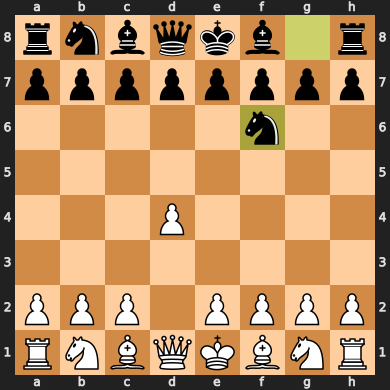

Enter your move in UCI (type x to quit): b1c3
LM plays: d7d5



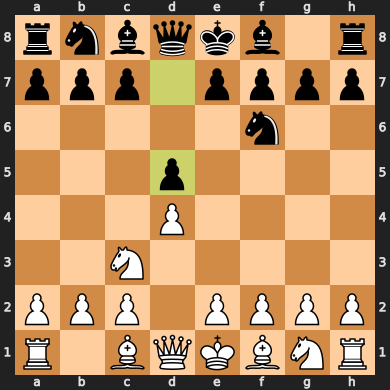

Enter your move in UCI (type x to quit): c1f3
c1f3 is not a legal move!
Legal move choices: c3e4, c3a4, h2h4, e2e3, c1f4, d1d3, c1h6, c3d5, b2b3, g1f3, e1d2, g2g4, c3b1, a2a3, g1h3, e2e4, c3b5, b2b4, c1d2, h2h3, a2a4, f2f4, a1b1, d1d2, c1e3, c1g5, f2f3, g2g3
Enter your move in UCI (type x to quit): c1g5
LM plays: b8d7



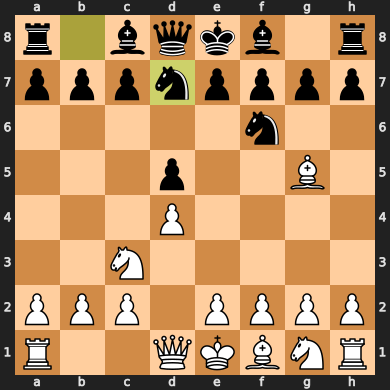

Enter your move in UCI (type x to quit): g1f3
LM plays: e7e6



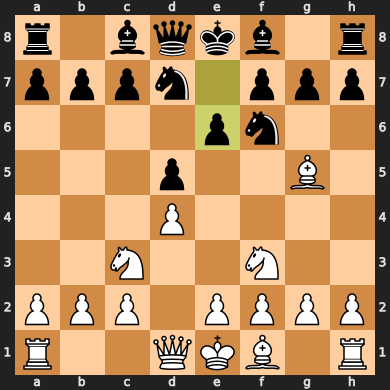

Enter your move in UCI (type x to quit): f3e5
LM plays: f8e7



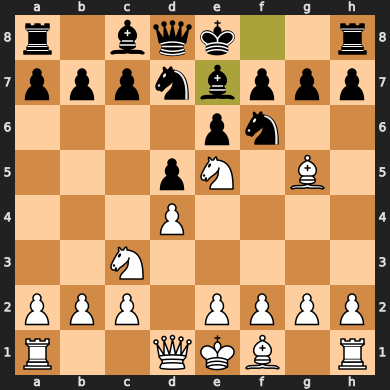

Enter your move in UCI (type x to quit): d1d3
LM plays: e8g8



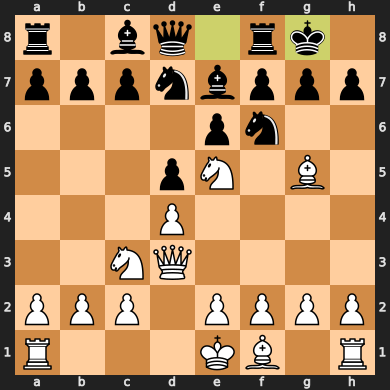

Enter your move in UCI (type x to quit): d3h3
LM plays: c7c5



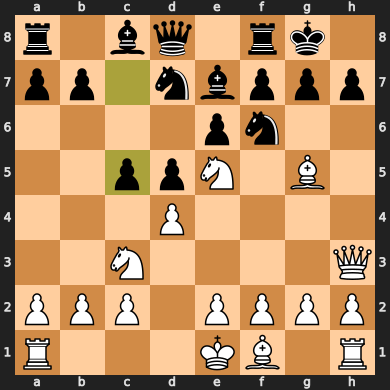

Enter your move in UCI (type x to quit): e2e3
LM plays: c5d4



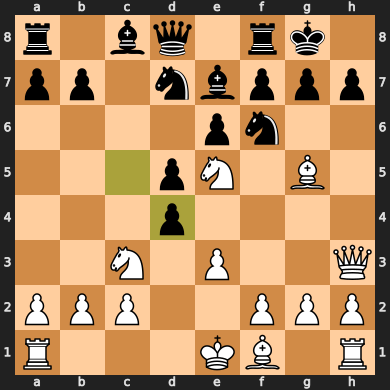

Enter your move in UCI (type x to quit): f1d3
LM plays: d4c3



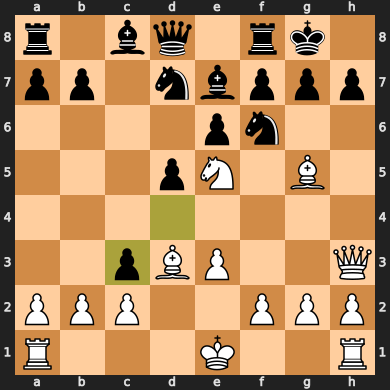

Enter your move in UCI (type x to quit): g5f6
LM plays: d7f6



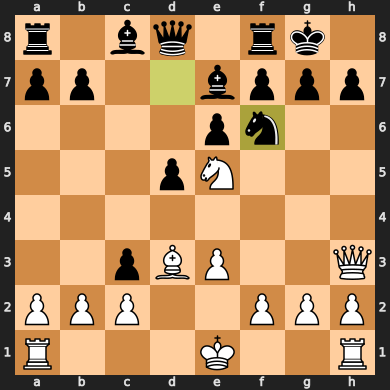

Enter your move in UCI (type x to quit): b2c3
LM plays: e7d6



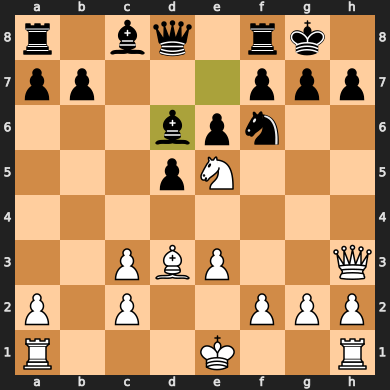

Enter your move in UCI (type x to quit): e5g4
LM plays: f6g4



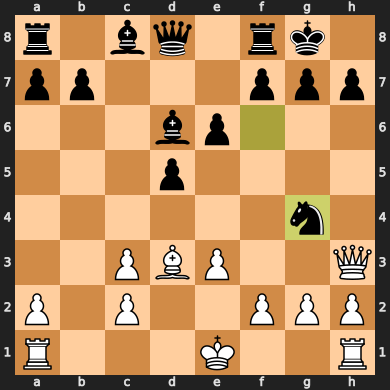

In [ ]:
def get_legal_moves(board):
  legal_moves = set()
  for move in board.legal_moves:
    uci_move = board.uci(move)
    legal_moves.add(uci_move)
    
  return legal_moves


board = chess.Board()
game_prefix = [tokenizer.bos_token_id]
game_prefix_str = ""

while True:
  while True:
    move = input("Enter your move in UCI (type x to quit): ")
    if move == "x":
      break
    else:
      legal_moves = get_legal_moves(board)
      if move in legal_moves:
        break
      else:
        print(colored(f"{move} is not a legal move!", 'red'))
        print("Legal move choices:", ", ".join(list(legal_moves)))
      
  if move == "x":
    break    
  # Make the move
  board.push_uci(move)

  if board.is_game_over():
    print("Well played MATE") 
    break
  elif board.is_stalemate():
    print("It's a STALE situation")
    break


  game_prefix.extend(tokenizer.encode(move, add_special_tokens=False, get_move_end_positions=False))
  game_prefix_str += move + " "

  greedy_game_prefix = list(game_prefix)
  prefix_tens = torch.tensor([greedy_game_prefix])
  pred_move = ""
  for idx in range(3):
    logits = model(prefix_tens)[0]
    last_token_logit = logits[0, -1, :]

    token_idx = torch.argmax(last_token_logit).item()
    current_token = tokenizer.decode_token(token_idx)
    pred_move += current_token

    if idx == 0 and current_token == tokenizer.eos_token:
      break

    greedy_game_prefix += [token_idx] 
    prefix_tens = torch.tensor([greedy_game_prefix])


  if pred_move == tokenizer.eos_token:
    print(colored("LM quits. Well played!", 'blue'))
    break

  if len(pred_move) == 6:
    pred_move = pred_move[:4]

  legal_moves = get_legal_moves(board)
  if pred_move in legal_moves:
    print(f"LM plays: {pred_move}")
  else:
    print(colored(f"Predicted move {pred_move} is illegal."), 'red')
    pred_move = random.sample(legal_moves, 1)[0]
    print("Randomly selected legal move:", pred_move)
  
  print()
  board.push_uci(pred_move)
  game_prefix.extend(tokenizer.encode(pred_move, add_special_tokens=False, 
                                      get_move_end_positions=False))
  game_prefix_str += pred_move + " "

  display(board)
  # break


print("Thanks for playing! Here's the full game")
print(game_prefix_str)

